#**Visualizing Intermediary Layer Activation Output**

First, we load our trained CNN...

In [67]:
from tensorflow import keras 
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

conv_net = keras.models.load_model("drive/My Drive/Teaching/Courses/BA 865/BA865-2022/Week 5/convnet_from_scratch.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, we load an impage to feed through the model...

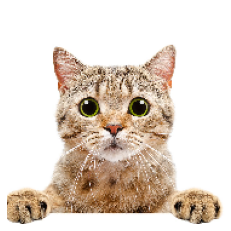

In [68]:
img_path = keras.utils.get_file(
    fname="cat10.jpg",
    origin="https://i.guim.co.uk/img/media/26392d05302e02f7bf4eb143bb84c8097d09144b/446_167_3683_2210/master/3683.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=49ed3252c0b2ffb49cf8b508892e452d")
 
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0) # add a dimension to the tensor (reflecting 'batch size' which my network will expect to receive as input)
    return array
  
img_tensor = get_img_array(img_path, target_size=(180, 180))

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [69]:
from tensorflow.keras import layers
  
layer_outputs = []
layer_names = [] 

# We are making a 'new' Keras model based on the single prior trained one, but with *many* different output branches.

# Iterate over all the layers in my prior model...
for layer in conv_net.layers:
  
    # If that layer is a 2D Convolution or a Max Pool layer... 
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(f'Current layer is {layer.name} and its output shape is {layer.output.shape}')
        # Take that layer's outputs and name and append them to a list (we are going to use all of these as 'different' output layers, across a series of new models)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Finally, define a new model as the trained model's inputs, mapped to the list of various layer outputs we created above.
# So, the new model takes images as input, and it will spit out a list of outputs (those associated with each successive Conv2D and pooling layer)
featuremap_model = keras.Model(inputs=conv_net.input, outputs=layer_outputs)

Current layer is conv2d and its output shape is (None, 178, 178, 32)
Current layer is max_pooling2d and its output shape is (None, 89, 89, 32)
Current layer is conv2d_1 and its output shape is (None, 87, 87, 64)
Current layer is max_pooling2d_1 and its output shape is (None, 43, 43, 64)
Current layer is conv2d_2 and its output shape is (None, 41, 41, 128)
Current layer is max_pooling2d_2 and its output shape is (None, 20, 20, 128)
Current layer is conv2d_3 and its output shape is (None, 18, 18, 256)
Current layer is max_pooling2d_3 and its output shape is (None, 9, 9, 256)
Current layer is conv2d_4 and its output shape is (None, 7, 7, 256)


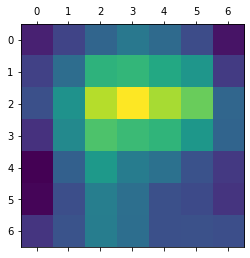

In [85]:
import matplotlib.pyplot as plt

featuremaps = featuremap_model.predict(img_tensor)

# What layer, and what filter do we want to look at?
layer = 8
filter = 3

# Let's plot the 1st feature map from the first Convolution layer.
# It seems to be detecting some edges.
plt.matshow(featuremaps[layer][0, :, :, filter], cmap="viridis")
plt.show()

#**Class Activation Heatmaps**

Let's get the prediction for our cat image... note that our model actually doesn't do well here; it predicts incorrectly.

In [86]:
preds = conv_net.predict(img_tensor)
print(f'Probability that this is a dog = {preds[0]}')

if np.round(preds[0]) == 0:
  print(f'Predicted class is cat.')
else:
  print(f'Predicted class is dog.')

Probability that this is a dog = [0.38764524]
Predicted class is cat.


Let's get the names of the layers from our model...

In [87]:
for layer in conv_net.layers:
    print(layer.name)

input_1
rescaling
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
conv2d_4
flatten
dense


Now, we make two more Keras models. The first one just takes a picture as input and feeds it through the CNN layers of the trained model. The second takes the output from the CNN layers, and feeds it through the dense layer to a prediction output. 

In [88]:
# The CNN base layers of our model.
last_conv_layer_name = "conv2d_4" 
classifier_layer_names = [
    "flatten",
    "dense",
]
last_conv_layer = conv_net.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(conv_net.inputs, last_conv_layer.output)

# The final dense layers of our model. 
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input 
for layer_name in classifier_layer_names:
    x = conv_net.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Now, we use GradientTape() to look at gradient of the class prediction w.r.t. activations that are coming out of the convolutional base-layers. 

In [89]:
import tensorflow as tf
  
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tensor)
    print(f'CNN base output shape is: {last_conv_layer_output.shape}')
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    print(f'Prediction output is {preds}.')
    pr_dog = preds[0]
    
grads = tape.gradient(pr_dog, last_conv_layer_output)

CNN base output shape is: (1, 7, 7, 256)
Prediction output is [[0.38764507]].


Now, we construct our heatmap. We take the product of the CNN base output (feature maps) and the gradients, to see what's most influencing 

(1, 7, 7, 256)
(256,)
(1, 7, 7, 256)
(7, 7, 256)


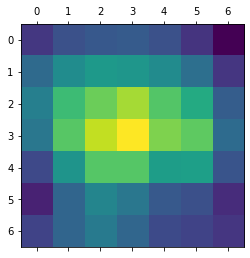

In [90]:
print(grads.shape)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # We get the average gradient associated with each filter.
print(pooled_grads.shape)

print(last_conv_layer_output.shape)
last_conv_layer_output = last_conv_layer_output.numpy()[0] # Here we are getting the processed image output from our Convolutional layers. 
print(last_conv_layer_output.shape)

# Here we are multiplying the average gradient associated with each filter by the processed image... positive gradients are driving toward 1, negative toward 0.
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# We then make our heatmap as the average value in each element position across the 256 gradient-weighted feature maps.
# That is, for each position in the 7x7 convolutional output, we've multiplied it by all the 256 filter-specific average gradients, and now we are averaging over the resulting 256 values.
# Higher value means we had more filters applying in this spot that were all driving us systematically toward a prediction of 1. Smaller means closer to prediction of 0. 
heatmap = np.mean(last_conv_layer_output, axis=-1)

# Here, we are are removing negative values and just setting them to 0's (can't draw a negative pixel value)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) # Here we are dividing by the maximum, so our values will all range from 0-1. 
plt.matshow(heatmap)

It appears to be something about the 'snout' that's driving the prediction.

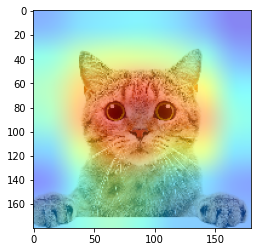

In [93]:
import matplotlib.cm as cm
  
img = img_tensor[0,:,:,:]

heatmap = np.uint8(255 * heatmap)
 
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
 
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)
 
superimposed_img = jet_heatmap * 0.9 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

plt.imshow(superimposed_img)
plt.show()